In [36]:
import argparse
from pathlib import Path

import shap
import shap.maskers
import torch
import transformers
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import util.io
import util.classification


NUM_SAMPLES_SHAP = 10

# Adapted from 
# https://markaicode.com/transformers-model-interpretability-lime-shap-tutorial/
class TransformerExplainer:
    """
    Production-ready explanation pipeline for transformer models
    """
    
    def __init__(self, model_dir: Path):
        device = 0 if torch.cuda.is_available() else -1

        self.model = transformers.AutoModelForSequenceClassification.from_pretrained(
            model_dir, reference_compile=False, attn_implementation="eager"
        ).to(device)
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)

        masker = shap.maskers.Text(self.tokenizer)
        self.shap_explainer = shap.Explainer(self.predict_proba, masker)
        
    def explain(self, text, method=None):
        """
        Generate explanations.
        """     
        return self.shap_explainer([text])  
    
    def batch_explain(self, texts):
        """
        Explain multiple texts efficiently.
        """
        return self.shap_explainer(texts)
    
    def predict_proba(self, texts) -> np.ndarray:
        """
        Predict classification probabilities for a list of texts, 
        returning probabilities for BOTH classes (N, 2) to satisfy SHAP's slicing.
        """
        # --- Normalize SHAP input (Ensure fix for previous TypeError is included) ---
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        if isinstance(texts, (list, tuple)):
            normalized_texts = []
            for t in texts:
                if isinstance(t, (list, np.ndarray)):
                    t = t[0] if len(t) > 0 else "" 
                normalized_texts.append(str(t)) 
            texts = normalized_texts
        elif isinstance(texts, str):
            texts = [texts]
        else:
            raise ValueError(f"Unsupported input type for texts: {type(texts)}")

        # Tokenize
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt"
        ).to(self.model.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits # Assumed shape (N, 1) for BCE model

            # Calculate P(Class 1) using Sigmoid
            p_positive = torch.sigmoid(logits) 
            
            # Calculate P(Class 0) = 1 - P(Class 1)
            p_negative = 1 - p_positive
            
            # Concatenate to create a tensor of shape (N, 2)
            probabilities = torch.cat((p_negative, p_positive), dim=-1)

        return probabilities.cpu().numpy()

    def _normalize_shap_input(self, texts):
        # --- Normalize SHAP input ---
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        if isinstance(texts, (list, tuple)):
            # Flatten nested single-item lists (SHAP often wraps them)
            texts = [t if isinstance(t, str) else str(t) for t in texts]
        return texts

def collate_fn(tokenizer, batch):
    texts = [b["text"] for b in batch]
    labels = torch.tensor([b["label"] for b in batch]).unsqueeze(1)
    enc = tokenizer(
        texts,
        padding="longest",
        truncation=False,
        max_length=8192,
        return_tensors="pt",
    )
    enc["labels"] = labels
    return enc


def _get_classification_texts(
    model_dir: Path,
    test_df: pd.DataFrame, 
    full_df: pd.DataFrame,
    max_length: int,
    label_column: str,
    max_context_turns: int
    ) -> list[str]:
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)
    # Build dataset and take a sample (too many samples make SHAP very slow)
    ds = util.classification.DiscussionDataset(
        target_df=test_df,
        full_df=full_df,
        tokenizer=tokenizer,
        max_length=max_length,
        label_column=label_column,
        max_context_turns=max_context_turns,
    )
    texts = [ds[i]["text"] for i in range(len(ds))]
    return texts

In [12]:
model_dir = Path("../checkpoints/mod/all/best_model")
graph_dir = Path("../graphs")
util.classification.set_seed(util.classification.SEED)
df = util.io.progress_load_csv(Path("../pefk.csv"))

"""augmented_moderation_plot(
    df,
    Path(args.mod_probability_file),
    args.mod_probability_thres,
    graph_dir=graph_dir,
)"""

print(
    "Running explanation algorithms on model for "
    f"N={NUM_SAMPLES_SHAP} test-set comments..."
)
classification_df = util.classification.preprocess_dataset(df)
_, _, test_df = util.classification.train_validate_test_split(
    classification_df,
    stratify_col="is_moderator",  # or "should_intervene"
    train_percent=0.7,
    validate_percent=0.2,
)
test_df = test_df.sample(n=NUM_SAMPLES_SHAP, random_state=42)

Loading dataset:   0%|           0%

Running explanation algorithms on model for N=2 test-set comments...


In [37]:
full_df = classification_df
max_length = 23983
label_column = "is_moderator"
max_context_turns = 4
print("Building test dataset for SHAP explanation...")
texts = _get_classification_texts(
    model_dir, 
    test_df, 
    full_df, 
    max_length, 
    label_column, 
    max_context_turns
)

Building test dataset for SHAP explanation...


KeyboardInterrupt: 

In [38]:
texts

['<CTX> <USR>Galassi</USR>  This is a CLAIMED #. The actual published list has 9 Jews on it - http://uk.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%BE%D1%80%D0%B3%D0%B0%D0%BD%D1%96%D0%B7%D0%B0%D1%82%D0%BE%D1%80%D1%96%D0%B2_%D0%93%D0%BE%D0%BB%D0%BE%D0%B4%D0%BE%D0%BC%D0%BE%D1%80%D1%83. </CTX> <CTX> <USR>Joel Slovo</USR> Is this number given, or is it based on a personal name count? Using google translate for ref. you put on the article, I can\'t see lists of people by nationality. Recall that the JTA states that the lists show that most of the organizers were jewish: http://www.jta.org/news/article/2009/06/15/1005888/jewish-group-objects-to-holodomor-lawsuit\n It states "The nation\'s security service is pressing the case against a list of former Soviet officials accused of committing the Holodomor, which caused the deaths of millions in Ukraine in 1932-33. Most of the names on the list were Jewish. ... Last July, the Ukrainian Security Service released a list of high-ran

In [39]:
print(f"Explaining {len(texts)} examples...")
explainer = TransformerExplainer(model_dir)
shap_values = explainer.batch_explain(texts)

Explaining 2 examples...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:10, 10.93s/it]               


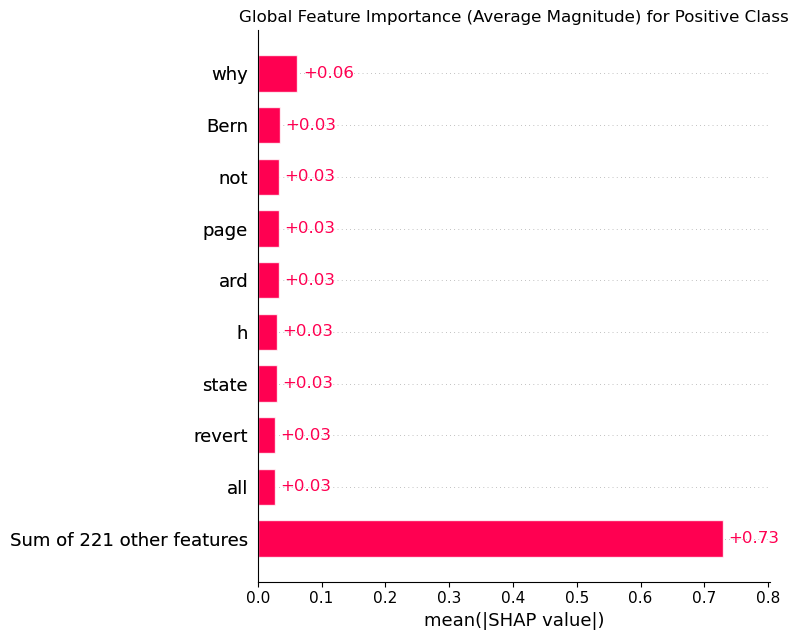

In [42]:
# -------------------------------------------------------------------
# ADDED SECTION: PLOT GLOBAL SHAP VALUES
# -------------------------------------------------------------------

# For binary classification, we typically focus on the positive class's 
# explanation, which is usually at index 1.
POSITIVE_CLASS_INDEX = 1 
plot_data = shap_values[:, :, POSITIVE_CLASS_INDEX]

# The SHAP Explanation object is sliced to isolate the values for the 
# target class across all texts and tokens: shap_values[:, :, POSITIVE_CLASS_INDEX]

# --- 1. Global Bar Plot (Average Magnitude) ---
# Shows the mean absolute impact of each word/feature.
plt.figure(figsize=(10, 6))
# Passing the full explanation object allows SHAP to handle the tokenization/data
shap.plots.bar(plot_data, show=False)
plt.title("Global Feature Importance (Average Magnitude) for Positive Class")
plt.tight_layout()
plt.show()